In [1]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import pyqg
from time import time
import os
import glob
from pyqg_generative.models.ols_model import OLSModel
from pyqg_generative.models.mean_var_model import MeanVarModel
from pyqg_generative.models.cgan_regression import CGANRegression
from pyqg_generative.tools.stochastic_pyqg import stochastic_QGModel
from pyqg_generative.tools.spectral_tools import spectrum
from pyqg_generative.tools.comparison_tools import *
import pyqg_parameterization_benchmarks as ppb
from pyqg_generative.tools.operators import Operator1, Operator2, PV_subgrid_forcing
from pyqg_generative.tools.parameters import EDDY_PARAMS
import json
%load_ext autoreload
%autoreload 3

/ext3/miniconda3/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Subgrid forcing at various resolutions

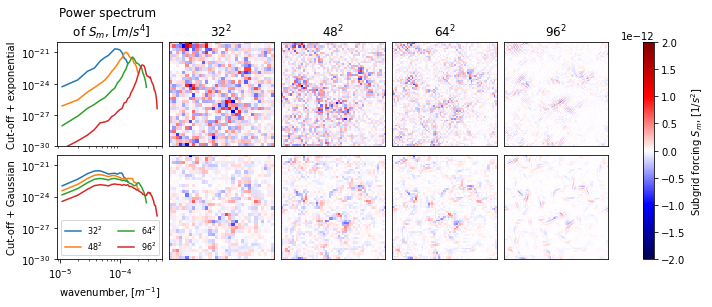

In [328]:
plt.rcParams.update({'font.size': 10})
q = xr.open_dataset('/scratch/pp2681/pyqg_generative/Reference-Default-scaled/eddy/reference_256/0.nc').q.isel(time=-1)
lev=1
if lev==1:
    ylim = [1e-30, 1e-20]
    vmax=2e-12
else:
    ylim = [1e-27, 1e-17]
    vmax=5e-11
fig, axs = plt.subplots(2,5,figsize=(12.5,4))
plt.subplots_adjust(hspace=0.08, wspace=0)
for j, (resolution, res_name) in enumerate(zip([32, 48, 64, 96], ['$32^2$', '$48^2$', '$64^2$', '$96^2$'])):
    for i, (operator, op_name) in enumerate(zip([Operator1, Operator2], ['cut-off + exponential', 'cut-off + Gaussian'])):
        #qc = operator(q, nc)
        forcing = xr.DataArray(PV_subgrid_forcing(q.values, resolution, operator, EDDY_PARAMS)[0], dims=('lev', 'y', 'x'))
        ax = axs[i][j+1]
        im = ax.imshow(forcing.isel(lev=lev).values, vmin=-vmax, vmax=vmax, cmap='seismic', interpolation='none')
        ax.set_box_aspect(1)
        if i==0:
            ax.set_title(res_name)
        ax.set_xticks([])
        ax.set_yticks([])
        
        sp = spectrum(time=slice(None,None))(forcing.expand_dims('time'))
        axs[i][0].loglog(sp.k, sp.isel(lev=lev).values, label=res_name)
        axs[i][0].set_box_aspect(1)
        
        axs[i][0].set_ylim(ylim)
        if i==1:
            axs[i][0].legend(ncol=2, fontsize=8)
plt.colorbar(im, ax=axs, label='Subgrid forcing $S_m$, [$1/s^2$]')
axs[1][0].set_xlabel('wavenumber, [$m^{-1}$]')
axs[0][0].set_title('Power spectrum \n of $S_m$, [$m/s^4$]')
axs[0][0].set_ylabel('Cut-off + exponential')
axs[1][0].set_ylabel('Cut-off + Gaussian')
axs[0][0].set_xticks([])
plt.savefig('paper_figures/forcing_lower.pdf', bbox_inches='tight', pad_inches=0)

# Convergence of cGAN

In [63]:
stats_none = xr.open_dataset('/scratch/pp2681/pyqg_generative/Reference-Default-scaled/models/Operator1-48/CGANRegression-None/model/stats.nc')
stats_correction = xr.open_dataset('/scratch/pp2681/pyqg_generative/Reference-Default-scaled/models/Operator1-48/CGANRegression/model/stats.nc')
stats_residual = xr.open_dataset('/scratch/pp2681/pyqg_generative/Reference-Default-scaled/models/Operator1-48/CGANRegression-residual/model/stats.nc')

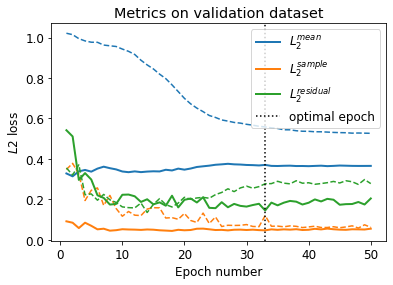

In [65]:
plt.rcParams.update({'font.size': 12})
line = stats_correction.L2_mean_test.plot(lw=2, label='$L_2^{mean}$')
stats_none.L2_mean_test.plot(color=line[0]._color, ls='--')
#stats_residual.L2_mean_test.plot(color=line[0]._color, ls='-.')
line = stats_correction.L2_total_test.plot(lw=2, label='$L_2^{sample}$')
stats_none.L2_total_test.plot(color=line[0]._color, ls='--')
#stats_residual.L2_total_test.plot(color=line[0]._color, ls='-.')
line = stats_correction.L2_residual_test.plot(lw=2, label='$L_2^{residual}$')
stats_none.L2_residual_test.plot(color=line[0]._color, ls='--')
#stats_residual.L2_residual_test.plot(color=line[0]._color, ls='-.')
plt.xlabel('Epoch number')
plt.ylabel('$L2$ loss')
plt.axvline(x=stats_correction.Epoch_opt, ls=':', color='k', label='optimal epoch')
plt.legend()
plt.title('Metrics on validation dataset')
plt.savefig('paper_figures/training.pdf', bbox_inches='tight', pad_inches=0)

# Metrics across models and resolutions

In [38]:
def L2(type='mean', model='OLSModel', operator='Operator1', resolution=64):
    folder = '/scratch/pp2681/pyqg_generative/Reference-Default-scaled/models/'
    file = os.path.join(folder, operator+'-'+str(resolution),model,'offline_test.nc')
    if os.path.exists(file):
        ds = xr.open_dataset(file)
        if type != 'var_ratio':
            return float(ds['L2_'+type])
        else:
            return float(ds[type].mean())
    else:
        print('Wrong path', file)

Wrong path /scratch/pp2681/pyqg_generative/Reference-Default-scaled/models/Operator1-96/CGANRegression-residual/offline_test.nc
Wrong path /scratch/pp2681/pyqg_generative/Reference-Default-scaled/models/Operator1-96/CGANRegression-residual/offline_test.nc
Wrong path /scratch/pp2681/pyqg_generative/Reference-Default-scaled/models/Operator1-96/CGANRegression-residual/offline_test.nc
Wrong path /scratch/pp2681/pyqg_generative/Reference-Default-scaled/models/Operator1-96/CGANRegression-residual/offline_test.nc
Wrong path /scratch/pp2681/pyqg_generative/Reference-Default-scaled/models/Operator2-96/CGANRegression-residual/offline_test.nc
Wrong path /scratch/pp2681/pyqg_generative/Reference-Default-scaled/models/Operator2-96/CGANRegression-residual/offline_test.nc
Wrong path /scratch/pp2681/pyqg_generative/Reference-Default-scaled/models/Operator2-96/CGANRegression-residual/offline_test.nc
Wrong path /scratch/pp2681/pyqg_generative/Reference-Default-scaled/models/Operator2-96/CGANRegression-r

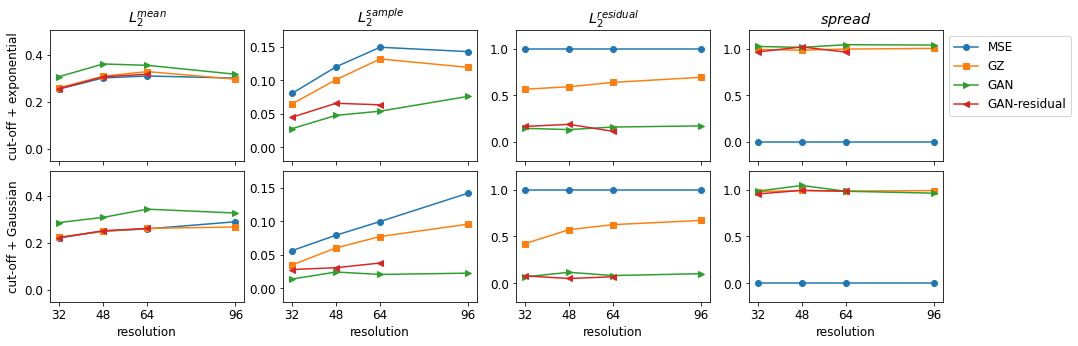

In [71]:
plt.rcParams.update({'font.size': 12})
markers = ['o', 's', '>', '<']
fig, axs = plt.subplots(2,4,figsize=(16,5))
plt.subplots_adjust(hspace=0.08, wspace=0.2)
for i, operator in enumerate(['Operator1', 'Operator2']):
    for j, (model, label) in enumerate(zip(['OLSModel', 'MeanVarModel', 'CGANRegression', 'CGANRegression-residual'], ['MSE', 'GZ', 'GAN', 'GAN-residual'])):
        res = [32, 48, 64, 96]
        L2_mean     = [L2('mean', model, operator, resolution) for resolution in res]
        L2_total    = [L2('total', model, operator, resolution) for resolution in res]
        L2_residual = [L2('residual', model, operator, resolution) for resolution in res]
        var_ratio = [L2('var_ratio', model, operator, resolution) for resolution in res]
        
        ax = axs[i][0]
        ax.plot(res, L2_mean, label=label, marker=markers[j])
        ax.set_ylim([-0.05, 0.505])
        #ax.set_ylim([1e-2, 2])
        #ax.set_yticks([1e-2, 1e-1, 1e0])
        
        ax = axs[i][1]
        ax.plot(res, L2_total, label=label, marker=markers[j])
        ax.set_ylim([-0.02, 0.175])
        #ax.set_ylim([1e-2, 2])
        #ax.set_yticks([1e-2, 1e-1, 1e0])
        #ax.set_yticklabels(['', '', ''])
        
        ax = axs[i][2]
        ax.plot(res, L2_residual, label=label, marker=markers[j])
        ax.set_ylim([-0.2, 1.2])
        #ax.set_ylim([1e-2, 2])
        #ax.set_yticks([1e-2, 1e-1, 1e0])
        #ax.set_yticklabels(['', '', ''])
        
        ax = axs[i][3]
        ax.plot(res, var_ratio, label=label, marker=markers[j])
        ax.set_ylim([-0.2, 1.2])
        
for j in range(4):
    axs[1][j].set_xlabel('resolution')
    axs[1][j].set_xticks([32, 48, 64, 96])
    axs[0][j].set_xticks([32, 48, 64, 96])
    axs[0][j].set_xticklabels([])
axs[0][0].set_title('$L_2^{mean}$')
axs[0][1].set_title('$L_2^{sample}$')
axs[0][2].set_title('$L_2^{residual}$')
axs[0][3].set_title('$spread$')

axs[0][0].set_ylabel('cut-off + exponential')
axs[1][0].set_ylabel('cut-off + Gaussian')

axs[0][3].legend(bbox_to_anchor=(1,1))

plt.savefig('paper_figures/metrics_updated.pdf', bbox_inches='tight', pad_inches=0)

# Snapshot

In [112]:
def imshow(ax, field, title, vmax, cmap='bwr'):
    if vmax is None:
        vmax = np.percentile(field.values.ravel(), 99)
    
    if field.min() < 0:
        vmin = -vmax
    else:
        vmin = 0

    im = ax.imshow(field, vmin=vmin, vmax=vmax, cmap=cmap, interpolation='none')
    ax.set_title(title)
    ax.set_xticks([])
    ax.set_yticks([])
    return im

In [113]:
def reader(path):
    ds = xr.open_dataset(path)
    time = slice(44,None)
    var1 = np.mean((ds.q_forcing_advection_res.isel(time=time, lev=0).astype('float64'))**2)
    var2 = np.mean((ds.q_forcing_advection_res.isel(time=time, lev=1).astype('float64'))**2)
    ds['CSD_res_ND'] = ds.CSD_res * ds.k / np.sqrt(var1 * var2)
    ds['CSD_gen_res_ND'] = ds.CSD_gen_res * ds.k / np.sqrt(var1 * var2)
    
    ds = ds.drop_vars(('PDF0', 'PDF1', 'PDF_gen0', 'PDF_gen1', 'PDF_mean0', 'PDF_mean1', 
                       'PDF_res0', 'PDF_res1', 'PDF_gen_res0', 'PDF_gen_res1', 'q_0', 'q_1'))
    
    time = slice(44,None)
    Nbins = 50
    target = 'q_forcing_advection'
    for lev in [0,1]:
        arr = ds[target].isel(time=time, lev=lev)
        mean, std = arr.mean(), arr.std()
        xmin = float(mean - 4*std); xmax = float(mean + 4*std)
        coords = None
        for suffix in ['', '_gen', '_mean']:
            array = ds[target+suffix].isel(time=time, lev=lev).values.ravel()
            points, density = PDF_histogram(array, xmin = xmin, xmax=xmax, Nbins=Nbins)
            if coords is None:
                coords=[coord(points, '$dq/dt, s^{-2}$')]
                
            ds['PDF'+suffix+str(lev)] = xr.DataArray(density, dims='q_'+str(lev), coords=coords,
                attrs={'long_name': 'subgrid forcing PDF'})
    
    for lev in [0,1]:
            arr = ds[target+'_res'].isel(time=time, lev=lev)
            mean, std = arr.mean(), arr.std()
            xmin = float(mean - 4*std); xmax = float(mean + 4*std)
            coords = None
            for suffix in ['_res', '_gen_res']:
                array = ds[target+suffix].isel(time=time, lev=lev).values.ravel()
                points, density = PDF_histogram(array, xmin = xmin, xmax=xmax, Nbins=Nbins)
                if coords is None:
                    coords=[coord(points, '$dq/dt, s^{-2}$')]
                ds['PDF'+suffix+str(lev)] = xr.DataArray(density, dims='dq_'+str(lev), coords=coords,
                    attrs={'long_name': 'subgrid forcing residual PDF'})
    
    return ds

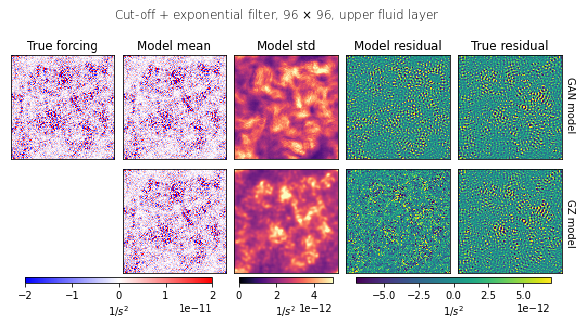

In [118]:
#prms = {'v_total': 8e-13, 'v_std': 2e-14, 'v_residual': 2e-13, 'resolution': 96, 'Operator': 'Operator1', 'lev': 1, 'run': 15, 'time': -1}
#prms = {'v_total': 3e-11, 'v_std': 2e-12, 'v_residual': 3e-11, 'resolution': 64, 'Operator': 'Operator2', 'lev': 0, 'run': 15, 'time': -1}
#prms = {'v_total': 4e-13, 'v_std': 3e-14, 'v_residual': 1e-13, 'resolution': 96, 'Operator': 'Operator1', 'lev': 1, 'run': 16, 'time': -1}
#prms = {'v_total': 8e-13, 'v_std': 8e-14, 'v_residual': 2e-13, 'resolution': 64, 'Operator': 'Operator1', 'lev': 1, 'run': 16, 'time': -1}

#prms = {'v_total': 4e-13, 'v_std': 3e-14, 'v_residual': 5e-14, 'file': 'snapshot_op1.pdf', 'suptitle': r'Cut-off + exponential filter, 96 $ \times $ 96, lower fluid layer', 'resolution': 96, 'Operator': 'Operator1', 'lev': 1, 'run': 16, 'time': -1}
#prms = {'v_total': 1.5e-13, 'v_std': 1.8e-14, 'v_residual': 3e-14, 'file': 'snapshot_op2.pdf', 'suptitle': r'Cut-off + Gaussian filter, 96 $ \times $ 96, lower fluid layer', 'resolution': 96, 'Operator': 'Operator2', 'lev': 1, 'run': 16, 'time': -1}
prms = {'v_total': 2e-11, 'v_std': 5e-12, 'v_residual': 7e-12, 'file': 'snapshot_op1_upper.pdf', 'suptitle': r'Cut-off + exponential filter, 96 $ \times $ 96, upper fluid layer', 'resolution': 96, 'Operator': 'Operator1', 'lev': 0, 'run': 16, 'time': -1}

plt.rcParams.update({'font.size': 10})
fig, axs = plt.subplots(2,5,figsize=(10,4))
plt.subplots_adjust(hspace=0.1, wspace=0.01)
gan = reader('/scratch/pp2681/pyqg_generative/Reference-Default-scaled/models/'+prms['Operator']+'-'+str(prms['resolution'])+'/CGANRegression/offline_test.nc').isel(run=prms['run'],time=prms['time'],lev=prms['lev'])
gz = reader('/scratch/pp2681/pyqg_generative/Reference-Default-scaled/models/'+prms['Operator']+'-'+str(prms['resolution'])+'/MeanVarModel/offline_test.nc').isel(run=prms['run'],time=prms['time'],lev=prms['lev'])
imshow(axs[0][0], gan.q_forcing_advection, 'True forcing', vmax=prms['v_total'])
art_mean = imshow(axs[0][1], gan.q_forcing_advection_mean, 'Model mean', vmax=prms['v_total'])
art_std  = imshow(axs[0][2], gan.q_forcing_advection_std, 'Model std', vmax=prms['v_std'], cmap='magma')
art_residual = imshow(axs[0][3], gan.q_forcing_advection_gen_res, 'Model residual', vmax=prms['v_residual'], cmap=None)
art_residual = imshow(axs[0][4], gan.q_forcing_advection_res, 'True residual', vmax=prms['v_residual'], cmap=None)

#gan['PDF'+str(prms['lev'])].plot(ax = axs[1][0], ls='--', lw=3, color='k', label='True')
#gan['PDF_gen'+str(prms['lev'])].plot(ax = axs[1][0], ls='-')
axs[1][0].remove()

imshow(axs[1][1], gz.q_forcing_advection_mean, '', vmax=prms['v_total'])
imshow(axs[1][2], gz.q_forcing_advection_std, '', vmax=prms['v_std'], cmap='magma')
imshow(axs[1][3], gz.q_forcing_advection_gen_res, '', vmax=prms['v_residual'], cmap=None)
imshow(axs[1][4], gz.q_forcing_advection_res, '', vmax=prms['v_residual'], cmap=None)

plt.colorbar(art_mean, cax=fig.add_axes([0.15,0.09,0.26,0.02]), orientation='horizontal', label='$1/s^2$')
plt.colorbar(art_std, cax=fig.add_axes([0.447,0.09,0.13,0.02]), orientation='horizontal', label='$1/s^2$')
plt.colorbar(art_residual, cax=fig.add_axes([0.61,0.09,0.27,0.02]), orientation='horizontal', label='$1/s^2$')
fig.text(0.9,0.62,'GAN model', rotation=-90)
fig.text(0.9,0.22,'GZ model', rotation=-90)

fig.suptitle(prms['suptitle'], y=1.05, fontweight='light')

plt.savefig(f'paper_figures/{prms["file"]}', bbox_inches='tight', pad_inches=0)

# Distribution plot

In [234]:
prms = {'resolution': 48, 'Operator': 'Operator1'}
gan = reader('/scratch/pp2681/pyqg_generative/Reference-Default-scaled/models/'+prms['Operator']+'-'+str(prms['resolution'])+'/CGANRegression/offline_test.nc')
gz = reader('/scratch/pp2681/pyqg_generative/Reference-Default-scaled/models/'+prms['Operator']+'-'+str(prms['resolution'])+'/MeanVarModel/offline_test.nc')
mse = reader('/scratch/pp2681/pyqg_generative/Reference-Default-scaled/models/'+prms['Operator']+'-'+str(prms['resolution'])+'/OLSModel/offline_test.nc')

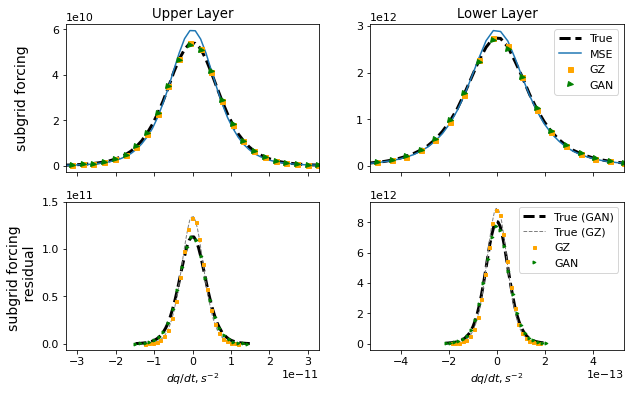

In [240]:
plt.rcParams.update({'font.size': 11})
fig, axs = plt.subplots(2,2,figsize=(10,6))
markers = ['o', 's', '>', '<']
colors = []

gan.PDF0.plot(ax=axs[0][0], color='k', lw=3, ls='--', label='True')
mse.PDF_gen0.plot(ax=axs[0][0], label='MSE', markevery=2)
gz.PDF_gen0.plot(ax=axs[0][0],marker=markers[1], label='GZ', lw=0, markevery=2, markersize=5, color='orange')
gan.PDF_gen0.plot(ax=axs[0][0],marker=markers[2], label='GAN', lw=0, markevery=2, markersize=5, color='green')
axs[0][0].set_xlim([-3.3e-11, 3.3e-11])
axs[0][0].set_xticklabels([])
axs[0][0].set_xlabel('')

gan.PDF_res0.plot(ax=axs[1][0], color='k', lw=3, ls='--')
gz.PDF_res0.plot(ax=axs[1][0], color='gray', lw=1, ls='--')
gz.PDF_gen_res0.plot(ax=axs[1][0], marker=markers[1], label='GZ', lw=0, markevery=2, markersize=3, color='orange')
gan.PDF_gen_res0.plot(ax=axs[1][0], marker=markers[2], label='GAN', lw=0, markevery=2, markersize=3, color='green')
axs[1][0].set_xlim([-3.3e-11, 3.3e-11])
axs[1][0].set_yticks([0, 5e+10, 1e+11, 15e+10])

#############################################
gan.PDF1.plot(ax=axs[0][1], color='k', lw=3, ls='--', label='True')
mse.PDF_gen1.plot(ax=axs[0][1], label='MSE', markevery=2)
gz.PDF_gen1.plot(ax=axs[0][1],marker=markers[1], label='GZ', lw=0, markevery=2, markersize=5, color='orange')
gan.PDF_gen1.plot(ax=axs[0][1],marker=markers[2], label='GAN', lw=0, markevery=2, markersize=5, color='green')
axs[0][1].set_xlim([-5.3e-13, 5.3e-13])
axs[0][1].set_xticklabels([])
axs[0][1].set_xlabel('')


gan.PDF_res1.plot(ax=axs[1][1], color='k', lw=3, ls='--', label='True (GAN)')
gz.PDF_res1.plot(ax=axs[1][1], color='gray', lw=1, ls='--', label='True (GZ)')
gz.PDF_gen_res1.plot(ax=axs[1][1], marker=markers[1], label='GZ', lw=0, markevery=2, markersize=3, color='orange')
gan.PDF_gen_res1.plot(ax=axs[1][1], marker=markers[2], label='GAN', lw=0, markevery=2, markersize=3, color='green')
axs[1][1].set_xlim([-5.3e-13, 5.3e-13])

axs[0][0].set_title('Upper Layer')
axs[0][1].set_title('Lower Layer')
axs[0][1].legend(bbox_to_anchor=(1,1))
axs[1][1].legend(bbox_to_anchor=(1,1))
axs[0][0].set_ylabel('subgrid forcing', labelpad=23, fontsize=14)
axs[1][0].set_ylabel('subgrid forcing \n residual', fontsize=14)
axs[0][1].set_ylabel('')
axs[1][1].set_ylabel('')

plt.savefig(f'paper_figures/pdf_op1_48.pdf', bbox_inches='tight', pad_inches=0)

# Power spectrum

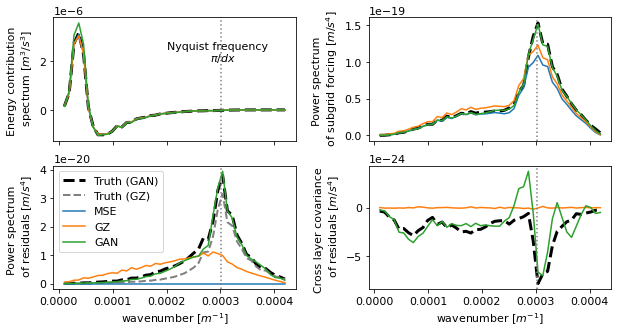

In [337]:
plt.rcParams.update({'font.size': 11})

operator = 'Operator2'
resolution = 96
lev = 0
gan = xr.open_dataset('/scratch/pp2681/pyqg_generative/Reference-Default-scaled/models/'+operator+'-'+str(resolution)+'/CGANRegression/offline_test.nc').isel(lev=lev)
gz = xr.open_dataset('/scratch/pp2681/pyqg_generative/Reference-Default-scaled/models/'+operator+'-'+str(resolution)+'/MeanVarModel/offline_test.nc').isel(lev=lev)
mse = xr.open_dataset('/scratch/pp2681/pyqg_generative/Reference-Default-scaled/models/'+operator+'-'+str(resolution)+'/OLSModel/offline_test.nc').isel(lev=lev)
#ds = xr.open_mfdataset('/scratch/pp2681/pyqg_generative/Reference-Default-scaled/eddy/Operator2-96/*.nc', combine='nested', concat_dim='run').isel(run=slice(275,300))

fig, axs = plt.subplots(2,2,figsize=(10,5))
plt.subplots_adjust(wspace=0.3)


ax = axs[0][0]
mse.Eflux.plot(ax=ax, label='Truth', color='k', ls='--', lw=3)
mse.Eflux_gen.plot(ax=ax, label='MSE')
gz.Eflux_gen.plot(ax=ax, label='GZ')
gan.Eflux_gen.plot(ax=ax, label='GAN')
ax.set_ylabel('Energy contribution \n spectrum [$m^3/s^3$]')
ax.set_xticks([0, 0.0001, 0.0002, 0.0003, 0.0004])
ax.set_xticklabels([])
ax.set_xlabel('')
ax.set_title('')

ax = axs[0][1]
mse.PSD.plot(ax=ax, label='Truth', color='k', ls='--', lw=3)
mse.PSD_gen.plot(ax=ax, label='MSE')
gz.PSD_gen.plot(ax=ax, label='GZ')
gan.PSD_gen.plot(ax=ax, label='GAN')
ax.set_ylabel('Power spectrum \n of subgrid forcing [$m/s^4$]')
ax.set_xticks([0, 0.0001, 0.0002, 0.0003, 0.0004])
ax.set_xticklabels([])
ax.set_xlabel('')
ax.set_title('')

ax = axs[1][0]
gan.PSD_res.plot(ax=ax, label='Truth (GAN)', ls='--', color='k', lw=3)
gz.PSD_res.plot(ax=ax, label='Truth (GZ)', ls='--', color='gray', lw=2)
mse.PSD_gen_res.plot(ax=ax, label='MSE')
gz.PSD_gen_res.plot(ax=ax, label='GZ')
gan.PSD_gen_res.plot(ax=ax, label='GAN')
ax.set_ylabel('Power spectrum \n of residuals [$m/s^4$]')
ax.set_title('')
ax.set_xticks([0, 0.0001, 0.0002, 0.0003, 0.0004])
ax.set_xlabel('wavenumber [$m^{-1}$]')
ax.legend()

ax = axs[1][1]
gan.CSD_res.plot(ax=ax, ls='--', color='k', lw=3)
ax.plot([],[])
gz.CSD_gen_res.plot(ax=ax, label='GZ')
gan.CSD_gen_res.plot(ax=ax, label='GAN')
ax.set_ylabel('Cross layer covariance \n of residuals [$m/s^4$]')
ax.set_title('')
ax.set_xticks([0, 0.0001, 0.0002, 0.0003, 0.0004])
ax.set_xlabel('wavenumber [$m^{-1}$]')

dx = gan.x[2] - gan.x[1]
for i in [0,1]:
    for j in [0,1]:
        axs[i][j].axvline(x=np.pi/dx, ls=':', color='gray')
axs[0][0].text(0.0002, 2.5e-6, 'Nyquist frequency')
axs[0][0].text(0.00028, 2e-6, '$\pi/dx$')

plt.savefig('paper_figures/spectra_offline.pdf', bbox_inches='tight', pad_inches=0)